# INSTALLING NECESSARY LIBRARIES

## METEOSTAT

    * PYTHON LIBRARY/API
    * Provides historical weather data from weather stations

In [3]:
!pip install meteostat

## GEOPY

    * PYTHON CLIENT FOR GEO-CODING SERVICES

In [5]:
!pip install geopy

# IMPORTING LIBRARIES

In [7]:
from datetime import datetime
from meteostat import Daily, Hourly, Stations

from geopy.distance import geodesic

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# LOCATION FOR Sceaux (7km of Paris, France)

In [9]:
lat_sceaux = 48.7780
long_sceaux = 2.2951

# GET WEATHER DATA FOR PERIOD December 2006 and November 2010

GET CLOSEST STATION FROM SCEAUX

In [12]:
start = datetime(2006, 12, 16)
end = datetime(2011, 11, 27)

In [13]:
def get_closest_stations(lat, lon, limit=5):
    # Fetch all stations in France
    stations = Stations().region('FR').fetch()
    
    # Calculate distance from given location
    stations['distance_km'] = stations.apply(lambda row: geodesic((lat, lon), (row['latitude'], row['longitude'])).km, axis=1)
    
    # Sort by distance and return top N
    return stations.sort_values('distance_km').head(1)

In [14]:
closest_station = get_closest_stations(48.7780, 2.2951) ## Giving manually the coordinates of Sceaux since geopy is not accurate

closest_station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance_km
id,,,,,,,,,,,,,,,,
07156,Paris-Montsouris,FR,J,07156,<NA>,48.8167,2.3333,75.0,Europe/Paris,1983-12-01,2025-01-13,1900-01-01,2022-03-28,1900-01-01,2021-01-01,5.137887


DAILY WEATHER

In [16]:
data = Daily(closest_station.index[0], start, end)
daily_weather_df = data.fetch()

Parameter	Description	                            Type
* date	The date string (YYYY-MM-DD)	            String
* tavg	The average air temperature in °C	        Float
* tmin	The minimum air temperature in °C	        Float
* tmax	The maximum air temperature in °C	        Float
* prcp	The daily precipitation total in mm	        Float
* snow	The maximum snow depth in mm	            Integer
* wdir	The average wind direction in degrees (°)	Integer
* wspd	The average wind speed in km/h	            Float
* wpgt	The peak wind gust in km/h	                Float
* pres	The average sea-level air pressure in hPa	Float
* tsun	The daily sunshine total in minutes (m)	    Integer

In [18]:
daily_weather_df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2006-12-16,6.2,4.0,8.5,<NA>,<NA>,<NA>,12.3,<NA>,1024.1,<NA>
2006-12-17,4.4,1.2,7.9,<NA>,<NA>,<NA>,4.6,<NA>,1029.5,<NA>
2006-12-18,4.6,3.4,5.9,<NA>,<NA>,<NA>,6.5,<NA>,1029.0,<NA>
2006-12-19,2.6,0.5,5.1,<NA>,<NA>,<NA>,14.8,<NA>,1034.0,<NA>
2006-12-20,2.9,0.5,5.6,<NA>,<NA>,<NA>,13.4,<NA>,1037.5,<NA>


In [19]:
daily_weather_df.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2011-11-23,11.2,9.1,13.7,<NA>,<NA>,<NA>,6.1,<NA>,1026.9,<NA>
2011-11-24,9.6,7.7,11.3,<NA>,<NA>,<NA>,6.0,<NA>,1031.6,<NA>
2011-11-25,7.5,5.0,10.0,<NA>,<NA>,<NA>,7.8,<NA>,1029.8,<NA>
2011-11-26,6.6,5.3,7.8,<NA>,<NA>,<NA>,9.1,<NA>,1032.6,<NA>
2011-11-27,10.3,6.2,13.7,<NA>,<NA>,<NA>,10.2,<NA>,1026.7,<NA>


In [20]:
daily_weather_df.shape

(1707, 10)

In [21]:
num_col = daily_weather_df.select_dtypes(include=['number']).columns.tolist()
                                         
for col in num_col:
    missing_rows = daily_weather_df[col].isnull().sum()
    total_rows = len(daily_weather_df[col])
    missing_ratio = missing_rows/total_rows
    print(f"Missing Ratio of {col} : {(missing_ratio*100):.2f}%")

Missing Ratio of tavg : 0.00%
Missing Ratio of tmin : 9.84%
Missing Ratio of tmax : 9.84%
Missing Ratio of prcp : 100.00%
Missing Ratio of snow : 100.00%
Missing Ratio of wdir : 100.00%
Missing Ratio of wspd : 0.12%
Missing Ratio of wpgt : 100.00%
Missing Ratio of pres : 0.06%
Missing Ratio of tsun : 100.00%


In [22]:
daily_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1707 entries, 2006-12-16 to 2011-11-27
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    1707 non-null   Float64
 1   tmin    1539 non-null   Float64
 2   tmax    1539 non-null   Float64
 3   prcp    0 non-null      Float64
 4   snow    0 non-null      Float64
 5   wdir    0 non-null      Float64
 6   wspd    1705 non-null   Float64
 7   wpgt    0 non-null      Float64
 8   pres    1706 non-null   Float64
 9   tsun    0 non-null      Float64
dtypes: Float64(10)
memory usage: 163.4 KB


In [23]:
# dropping columns have no values
daily_weather_df.drop(columns=['prcp', 'snow', 'wdir', 'wpgt', 'tsun'], inplace=True)

In [24]:
# filling missing values with time interpolation
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)
daily_weather_df = daily_weather_df.sort_index()

daily_weather_df = daily_weather_df.interpolate(method="time")

In [25]:
daily_weather_df.columns

Index(['tavg', 'tmin', 'tmax', 'wspd', 'pres'], dtype='object')

In [26]:
print(f"Shape : {daily_weather_df.shape}")
print(f"NULL COUNT : ")
daily_weather_df.isnull().sum()

Shape : (1707, 5)
NULL COUNT : 


tavg    0
tmin    0
tmax    0
wspd    0
pres    0
dtype: int64

## HOURLY WEATHER

In [80]:
data = Hourly(closest_station.index[0], start, end)
hourly_weather_df = data.fetch()

In [82]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [84]:
# MISSING ROWS
null_rows = hourly_weather_df[hourly_weather_df.isnull().all(axis=1)]
null_rows.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2010-06-29 09:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-03-06 06:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2011-05-08 11:00:00,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [86]:
hourly_weather_df.shape

(42287, 11)

In [88]:
hourly_weather_df.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2011-11-26 20:00:00,6.80,4.80,87.00,0.00,<NA>,200.00,14.80,<NA>,1030.60,<NA>,<NA>
2011-11-26 21:00:00,6.60,4.80,88.00,<NA>,<NA>,200.00,13.00,<NA>,1030.10,<NA>,<NA>
2011-11-26 22:00:00,6.40,4.60,88.00,0.00,<NA>,190.00,11.20,<NA>,1029.90,<NA>,<NA>
2011-11-26 23:00:00,6.20,4.40,88.00,0.00,<NA>,200.00,11.20,<NA>,1029.60,<NA>,<NA>
2011-11-27 00:00:00,6.40,4.90,90.00,<NA>,<NA>,210.00,14.80,<NA>,1029.00,<NA>,<NA>


In [90]:
num_col1 = hourly_weather_df.select_dtypes(include=['number']).columns.tolist()
col_to_interpolate = []

for col in num_col1:
    missing_rows = hourly_weather_df[col].isnull().sum()
    total_rows = len(hourly_weather_df[col])
    missing_ratio = missing_rows/total_rows
    print(f"Missing Ratio of {col} : {(missing_ratio*100):.2f}%")
    if (missing_ratio * 100) < 1:
        col_to_interpolate.append(col)

print("\n", col_to_interpolate)

Missing Ratio of temp : 0.02%
Missing Ratio of dwpt : 0.09%
Missing Ratio of rhum : 0.09%
Missing Ratio of prcp : 37.91%
Missing Ratio of snow : 100.00%
Missing Ratio of wdir : 0.10%
Missing Ratio of wspd : 0.10%
Missing Ratio of wpgt : 100.00%
Missing Ratio of pres : 0.09%
Missing Ratio of tsun : 100.00%
Missing Ratio of coco : 100.00%

 ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']


In [92]:
# dropping columns have no values
hourly_weather_df.drop(columns=['snow', 'wpgt', 'tsun', 'coco'], inplace=True)

In [94]:
# setting datetime as index
hourly_weather_df.index = pd.to_datetime(hourly_weather_df.index)
hourly_weather_df = hourly_weather_df.sort_index()

In [96]:
# filling (~ <1%) missing values with time interpolation
for col in col_to_interpolate:
    hourly_weather_df[col] = hourly_weather_df[col].interpolate(method="time").bfill().ffill()

In [98]:
hourly_weather_df.columns

Index(['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres'], dtype='object')

In [100]:
print("After Interpolation\n")
hourly_weather_df.describe()

After Interpolation



,temp,dwpt,rhum,prcp,wdir,wspd,pres
count,42287.00,42287.00,42287.00,26256.00,42287.00,42287.00,42287.00
mean,12.51,6.80,70.78,0.07,189.74,10.82,1016.58
std,6.99,5.58,16.59,0.48,103.77,5.27,9.37
min,-8.70,-17.00,16.00,0.00,0.00,0.00,970.70
25%,7.50,3.00,59.00,0.00,110.00,7.60,1011.30
50%,12.70,7.30,74.00,0.00,200.00,11.20,1017.00
75%,17.50,10.90,84.00,0.00,270.00,14.80,1022.60
max,36.40,22.20,99.00,27.00,360.00,48.20,1043.50


In [137]:
print("Before prcp filling: ")
hourly_weather_df['prcp'] = hourly_weather_df['prcp'].round(1)
before_prcp = hourly_weather_df['prcp']
hourly_weather_df['prcp'].describe()

Before prcp filling: 


count   42287.00
mean        0.39
std         0.92
min         0.00
25%         0.00
50%         0.00
75%         0.50
max        27.00
Name: prcp, dtype: float64

In [104]:
hourly_weather_df['prcp'].isnull().sum()

16031

In [106]:
## FILLING <+3 hour gap in precipitation

# Step A: Detect gaps
mask_na = hourly_weather_df['prcp'].isna()        # series of bool
gap_id = (mask_na != mask_na.shift()).cumsum()    # series of shifted mask_na cumulative sum
gaps = hourly_weather_df.groupby(gap_id)          # group by gap id dict with gaps_id as key and group as column

In [108]:
# Step B: Get group length and apply linear fill between gaps
for gid, group in gaps:
    if not group['prcp'].isna().all(): ## Ignoring groups with some prcp valid values
        continue

    gap_len = len(group)

    if gap_len <= 3:
        start_index = group.index[0] - pd.Timedelta(hours=1)
        end_index = group.index[-1] + pd.Timedelta(hours=1)

        start_value = hourly_weather_df['prcp'].get(start_index, np.nan)
        end_value = hourly_weather_df['prcp'].get(end_index, np.nan)

        if pd.notna(start_value) and pd.notna(end_value) and start_value > 0 and end_value > 0:
            hourly_weather_df.loc[group.index, 'prcp'] = np.linspace(start_value, end_value, gap_len+2)[1:-1]

In [109]:
hourly_weather_df['prcp'].isnull().sum()

15381

In [112]:
## Climate + Stochastic Sampling for long gaps

hourly_weather_df['month'] = hourly_weather_df.index.month
hourly_weather_df['hour'] = hourly_weather_df.index.hour

climate_groups = hourly_weather_df.groupby(['month', 'hour'])['prcp'].apply(list)

In [114]:
np.random.seed(42)

def stochastic_fill(row):
    if pd.isna(row['prcp']):
        values = [v for v in climate_groups.loc[(row['month'], row['hour'])] if pd.notna(v)]
        if len(values) > 0:
            return np.random.choice(values)  # random draw from historical values
        else:
            return 0.0  # fallback
    else:
        return row['prcp']

hourly_weather_df['prcp'] = hourly_weather_df.apply(stochastic_fill, axis=1)

# Clean up helper columns
hourly_weather_df.drop(columns=['month', 'hour'], inplace=True)

In [115]:
hourly_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42287 entries, 2006-12-16 00:00:00 to 2011-11-27 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    42287 non-null  Float64
 1   dwpt    42287 non-null  Float64
 2   rhum    42287 non-null  Float64
 3   prcp    42287 non-null  float64
 4   wdir    42287 non-null  Float64
 5   wspd    42287 non-null  Float64
 6   pres    42287 non-null  Float64
dtypes: Float64(6), float64(1)
memory usage: 3.8 MB


In [118]:
hourly_weather_df['prcp'].isnull().sum()

0

In [128]:
print("After prcp filling:\n")
hourly_weather_df['prcp'] = hourly_weather_df['prcp'].round(1)
after_prcp = hourly_weather_df['prcp']
hourly_weather_df['prcp'].describe()

After prcp filling:



count   42287.00
mean        0.39
std         0.92
min         0.00
25%         0.00
50%         0.00
75%         0.50
max        27.00
Name: prcp, dtype: float64

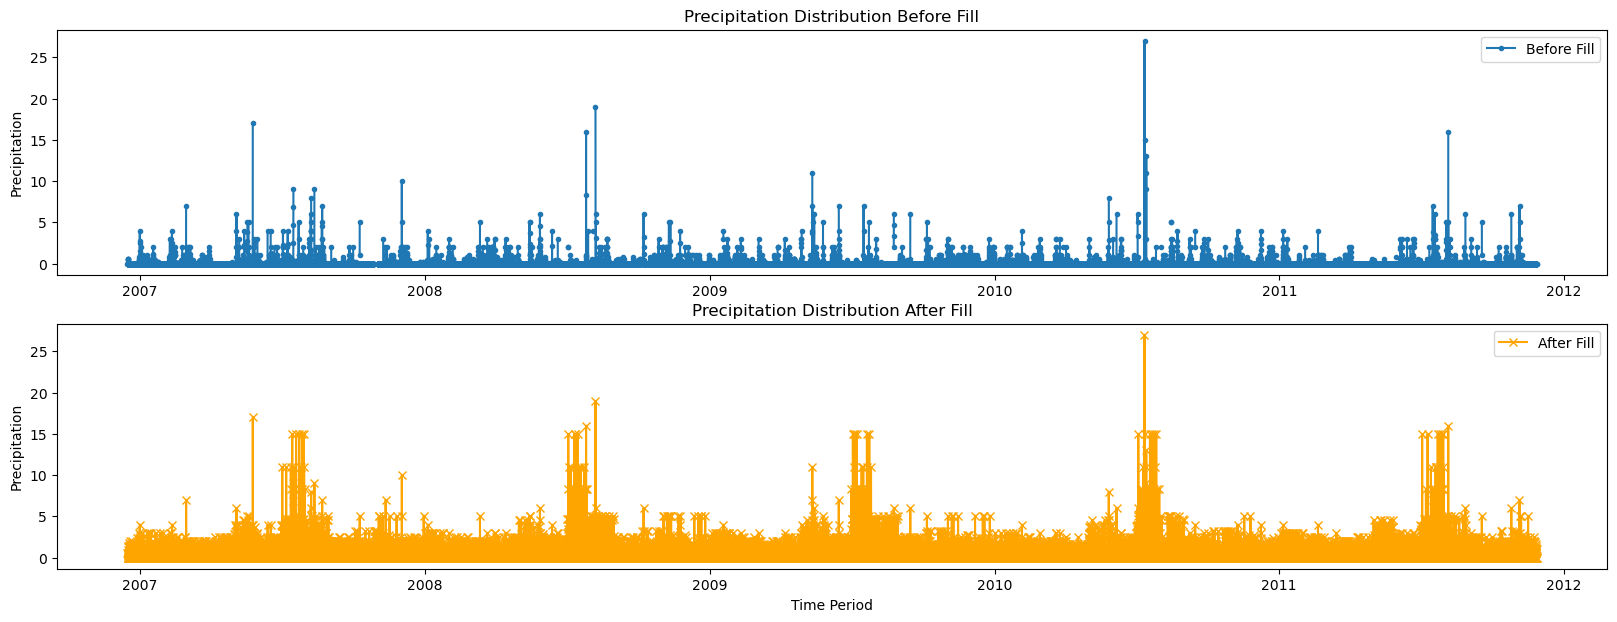

In [130]:
plt.figure(figsize=(20, 7))
plt.subplot(2,1,1)
plt.plot(hourly_weather_df.index, before_prcp, marker='o', markersize=3, label="Before Fill")
plt.ylabel("Precipitation")
plt.title("Precipitation Distribution Before Fill")
plt.legend()

plt.subplot(2,1,2)
plt.plot(hourly_weather_df.index, after_prcp, marker='x', label="After Fill", color='orange')
plt.xlabel("Time Period")
plt.ylabel("Precipitation")
plt.title("Precipitation Distribution After Fill")

plt.legend()
plt.show()

In [131]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = data[(data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))]
    return outliers

s = pd.Series(before_prcp)
outliers = find_outliers_iqr(s)
print(f"Before: \n {len(outliers)} outliers \n {before_prcp.skew():.2f} skewness")

s1 = pd.Series(after_prcp)
outliers1 = find_outliers_iqr(s1)
print(f"\nAfter: \n {len(outliers1)} outliers \n {after_prcp.skew():.2f} skewness")

Before: 
 2663 outliers 
 16.97 skewness

After: 
 3812 outliers 
 6.94 skewness


In [134]:
hourly_weather_df.to_csv("paris_sceaux_weather.csv")